In [2]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio.features
import rasterio.warp    
import whitebox
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import reproject, calculate_default_transform
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import Point
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import uniform, randint, loguniform
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

c:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Yield_Prediction\.venv\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
#Looking at the metadata and crs of the data that we have

with rasterio.open(r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Data_Raw\2022_farmcrew_n58\USDA_Central Farm_2-71_2022_Soybeans_1\CentralFarm_2-71_2022_Soyb_sph_field2rst_kriged.tif") as src:
    print("\n📊 Raster Metadata:")
    print(" - CRS:", src.crs)
    print(" - Shape:", (src.height, src.width))   # rows, cols
    print(" - Bounds:", src.bounds)
    print(" - Resolution:", src.res)
    print(" - Band count:", src.count)
    print(" - Data type:", src.dtypes)
    print(" - Transform:", src.transform)


📊 Raster Metadata:
 - CRS: EPSG:32618
 - Shape: (132, 76)
 - Bounds: BoundingBox(left=337665.1012349218, bottom=4320176.719129506, right=338047.70454867795, top=4320840.084564871)
 - Resolution: (5.034254128370728, 5.025495722466572)
 - Band count: 1
 - Data type: ('float32',)
 - Transform: | 5.03, 0.00, 337665.10|
| 0.00,-5.03, 4320840.08|
| 0.00, 0.00, 1.00|


In [4]:
#Let;s load all the fields' data:



# 👉 PATH TO ONE CROP FILE

fn = r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\Raw Yield data\soybeans.parquet"
#Count the number of rows in the file
df = pd.read_parquet(fn)

print(f"Number of rows in the file: {len(df)}")

print(df.info())  # get a summary of the data

#count the number and name of unique fields
print(f"Number of unique fields: {df['field'].nunique()}")
print(f"Unique fields: {df['field'].unique()}")

total_rows = len(df)
missing_per_col = df.isna().sum().to_frame('NaN_count')
missing_per_col['percent'] = 100 * missing_per_col['NaN_count'] / total_rows
print(missing_per_col)

df_yield = df

Number of rows in the file: 611315
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611315 entries, 0 to 611314
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       611315 non-null  float64
 1   y       611315 non-null  float64
 2   yield   611315 non-null  float64
 3   field   611315 non-null  object 
 4   year    611315 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 23.3+ MB
None
Number of unique fields: 108
Unique fields: ['Central Farm_1-14A' 'Central Farm_1-14B' 'Central Farm_1-14C'
 'Central Farm_1-20A' 'Central Farm_1-20B' 'Central Farm_1-20C'
 'Central Farm_2-32A' 'Central Farm_2-51' 'Central Farm_2-71'
 'Central Farm_2-72' 'Central Farm_4-16' 'Central Farm_4-23A'
 'Central Farm_4-25' 'East Farm_5-23' 'East Farm_5-45A' 'East Farm_5-45D'
 'Linkage Farm_EB-3' 'APU_1-98' 'Central Farm_1-13' 'Central Farm_1-21'
 'Central Farm_1-33' 'Central Farm_1-34' 'Central Farm_1-37'
 'Central Farm_1-7

In [5]:
print(df_yield.head(50))

                x             y      yield               field  year
0   336575.242354  4.322261e+06  68.618011  Central Farm_1-14A  2014
1   336580.326059  4.322261e+06  63.755882  Central Farm_1-14A  2014
2   336570.158649  4.322256e+06  70.386627  Central Farm_1-14A  2014
3   336575.242354  4.322256e+06  66.414635  Central Farm_1-14A  2014
4   336580.326059  4.322256e+06  59.465141  Central Farm_1-14A  2014
5   336585.409764  4.322256e+06  55.322681  Central Farm_1-14A  2014
6   336559.991239  4.322251e+06  78.832695  Central Farm_1-14A  2014
7   336565.074944  4.322251e+06  73.406586  Central Farm_1-14A  2014
8   336570.158649  4.322251e+06  67.883461  Central Farm_1-14A  2014
9   336575.242354  4.322251e+06  61.420727  Central Farm_1-14A  2014
10  336580.326059  4.322251e+06  53.015484  Central Farm_1-14A  2014
11  336585.409764  4.322251e+06  51.103939  Central Farm_1-14A  2014
12  336590.493469  4.322251e+06  48.832870  Central Farm_1-14A  2014
13  336554.907534  4.322246e+06  8

In [6]:


dst_dem_resampled = r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\DEM_5m_UTM18.tif"

# Step 1: Open the resampled DEM
with rasterio.open(dst_dem_resampled) as dem_src:

    # Step 2: Create list of (x, y) coordinate pairs
    coords = list(zip(df_yield['x'], df_yield['y']))

    # Step 3: Sample elevation values at those coordinates
    elevation_vals = [val[0] for val in dem_src.sample(coords)]

# Step 4: Add to DataFrame
df_yield['elevation'] = elevation_vals

# Step 5: Preview
(df_yield.head())

,x,y,yield,field,year,elevation
0,336575.242354,4.322261e+06,68.618011,Central Farm_1-14A,2014,45.632698
1,336580.326059,4.322261e+06,63.755882,Central Farm_1-14A,2014,45.842655
2,336570.158649,4.322256e+06,70.386627,Central Farm_1-14A,2014,45.935165
3,336575.242354,4.322256e+06,66.414635,Central Farm_1-14A,2014,46.113899
4,336580.326059,4.322256e+06,59.465141,Central Farm_1-14A,2014,46.339870


In [7]:

# 1) Make a GeoDataFrame assuming your x,y are in EPSG:32618
gdf = gpd.GeoDataFrame(
    df_yield,
    geometry=gpd.points_from_xy(df_yield['x'], df_yield['y']),
    crs='EPSG:32618'  # <- IMPORTANT: change if wrong
)

# 2) Check vs DEM bounds
dem_path = r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\DEM_5m_UTM18.tif"
with rasterio.open(dem_path) as src:
    b = src.bounds
    print("DEM CRS:", src.crs)
    print("DEM bounds:", b)

inside = (
    (gdf.geometry.x >= b.left) & (gdf.geometry.x <= b.right) &
    (gdf.geometry.y >= b.bottom) & (gdf.geometry.y <= b.top)
)
print("Total points:", len(gdf))
print("Points inside DEM bounds:", inside.sum(), f"({inside.mean()*100:.2f}%)")


DEM CRS: EPSG:32618
DEM bounds: BoundingBox(left=330908.9440308713, bottom=4318195.756654576, right=343368.72299858887, top=4323573.037077616)
Total points: 611315
Points inside DEM bounds: 611281 (99.99%)


In [8]:
#print null values in the elevation column
print(df_yield['elevation'].isnull().sum())


print(df_yield['elevation'].describe())

0
count    611315.000000
mean         38.389301
std           6.993848
min           0.000000
25%          32.996063
50%          38.237869
75%          42.904743
max          80.984177
Name: elevation, dtype: float64


In [9]:

wbt = whitebox.WhiteboxTools()

# Set the working directory (optional, but helpful)
wbt.set_working_dir("C:\\Users\\acer\\OneDrive - Texas State University\\ChoLab\\USDA Crop yield Stability Study\\BARC_Yield_Analysis\\Prediction\\Data")

wbt.slope(
    dem="C:\\Users\\acer\\OneDrive - Texas State University\\ChoLab\\USDA Crop yield Stability Study\\BARC_Yield_Analysis\\Prediction\\Data\\DEM_5m_UTM18.tif",      # Input DEM
    output="C:\\Users\\acer\\OneDrive - Texas State University\\ChoLab\\USDA Crop yield Stability Study\\BARC_Yield_Analysis\\Prediction\\Data\\slope.tif",           # Output slope raster
    zfactor=None                  # Optional: Use if elevation is in meters and coordinates are in degrees
)

wbt.aspect(
    dem="C:\\Users\\acer\\OneDrive - Texas State University\\ChoLab\\USDA Crop yield Stability Study\\BARC_Yield_Analysis\\Prediction\\Data\\DEM_5m_UTM18.tif",      # Input DEM
    output="C:\\Users\\acer\\OneDrive - Texas State University\\ChoLab\\USDA Crop yield Stability Study\\BARC_Yield_Analysis\\Prediction\\Data\\aspect.tif",          # Output aspect raster
    zfactor=None                  # Optional: Use if elevation is in meters and coordinates are in degrees
)


.\whitebox_tools.exe --run="Slope" --wd="C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data" --dem='C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\DEM_5m_UTM18.tif' --output='C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\slope.tif' --units=degrees -v --compress_rasters=False

****************************
* Welcome to Slope         *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%

0

In [10]:
with rasterio.open(r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\slope.tif") as slope_src:
    coords = list(zip(df_yield['x'], df_yield['y']))
    slope_vals = [val[0] for val in slope_src.sample(coords)]

with rasterio.open(r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\aspect.tif") as aspect_src:
    coords = list(zip(df_yield['x'], df_yield['y']))
    aspect_vals = [val[0] for val in aspect_src.sample(coords)]

df_yield['slope'] = slope_vals
df_yield['aspect'] = aspect_vals
df_yield.head()

,x,y,yield,field,year,elevation,slope,aspect
0,336575.242354,4.322261e+06,68.618011,Central Farm_1-14A,2014,45.632698,5.619898,339.101105
1,336580.326059,4.322261e+06,63.755882,Central Farm_1-14A,2014,45.842655,5.968995,337.149445
2,336570.158649,4.322256e+06,70.386627,Central Farm_1-14A,2014,45.935165,5.391035,335.693298
3,336575.242354,4.322256e+06,66.414635,Central Farm_1-14A,2014,46.113899,5.871187,336.441437
4,336580.326059,4.322256e+06,59.465141,Central Farm_1-14A,2014,46.339870,6.242173,336.157227


In [11]:
print("Df Yield describe: ",df_yield.describe())
missing_slope = (df_yield['slope'] <= 0).sum()
missing_aspect = (df_yield['aspect'] <= 0).sum()

print("Rows with NoData slope (0):", missing_slope)
print("Rows with NoData aspect (0):", missing_aspect)

Df Yield describe:                     x             y          yield           year  \
count  611315.000000  6.113150e+05  611315.000000  611315.000000   
mean   337339.638666  4.321327e+06      46.694985    2019.207328   
std      2571.816114  8.672437e+02      16.998010       2.978032   
min    330893.532259  4.318616e+06       4.139045    2014.000000   
25%    336099.599602  4.320616e+06      34.509420    2017.000000   
50%    336840.073515  4.321341e+06      46.845428    2019.000000   
75%    339214.129061  4.321947e+06      59.010979    2022.000000   
max    342733.656286  4.323242e+06     116.790192    2024.000000   

           elevation          slope         aspect  
count  611315.000000  611315.000000  611315.000000  
mean       38.389301       0.518345     187.043335  
std         6.993848     244.391876     266.625977  
min         0.000000  -32768.000000  -32768.000000  
25%        32.996063       1.187542     104.177971  
50%        38.237869       2.018188     195.36261

In [12]:
df_yield = df_yield[(df_yield['slope'] >= 0) & (df_yield['aspect'] >= 0)]

# 3. Confirm
print("Remaining rows:", len(df_yield))

Remaining rows: 611229


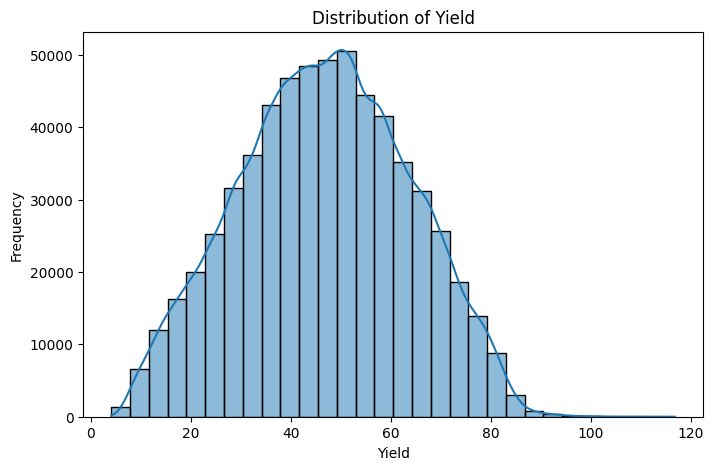

In [ ]:
# Distribution plot of yield
plt.figure(figsize=(8, 5))
sns.histplot(df_yield['yield'], bins=30, kde=True)
plt.title("Distribution of Yield")
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.show()


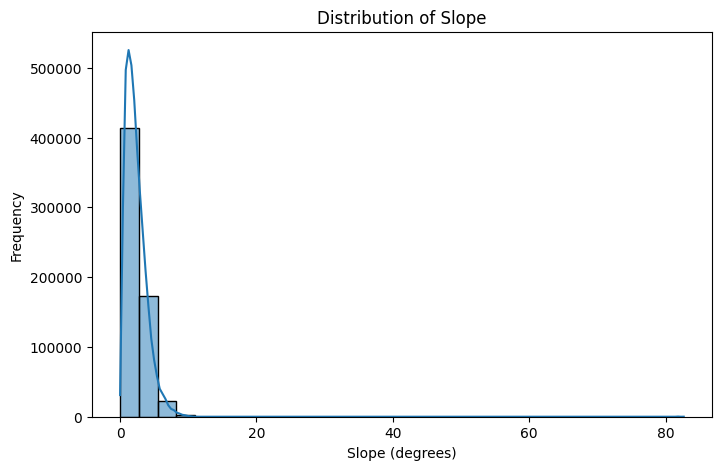

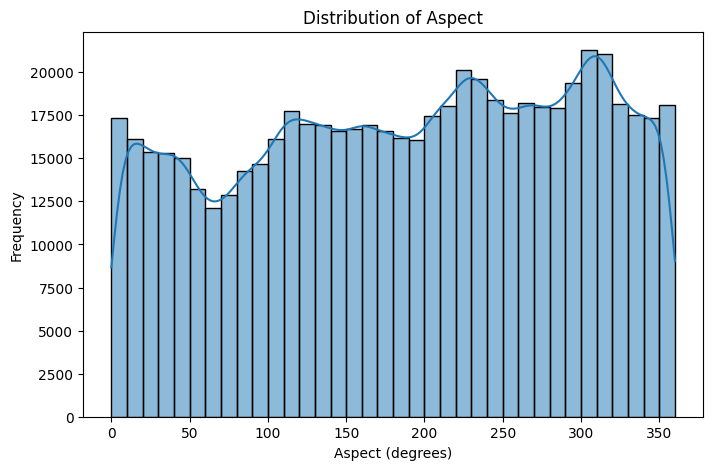

In [47]:
plt.figure(figsize=(8, 5))
sns.histplot(df_yield['slope'], bins=30, kde=True)
plt.title("Distribution of Slope")
plt.xlabel("Slope (degrees)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_yield['aspect'], bins=36, kde=True)  # 36 bins for 10° intervals
plt.title("Distribution of Aspect")
plt.xlabel("Aspect (degrees)")
plt.ylabel("Frequency")
plt.show()


In [22]:
#Clearning data



# 3.  Optionally: treat physically impossible values as NA as well
df_yield.loc[~df_yield["slope"].between(0, 90),  "slope"]  = pd.NA
df_yield.loc[~df_yield["aspect"].between(0, 360), "aspect"] = pd.NA

df_yield = df_yield.dropna(subset=["slope", "aspect"]).reset_index(drop=True)

In [13]:
print(df_yield.describe())

                   x             y          yield           year  \
count  611229.000000  6.112290e+05  611229.000000  611229.000000   
mean   337340.542897  4.321327e+06      46.697351    2019.207287   
std      2570.866923  8.671467e+02      16.997666       2.978234   
min    330929.234646  4.318616e+06       4.139045    2014.000000   
25%    336100.004450  4.320619e+06      34.512669    2017.000000   
50%    336840.073515  4.321341e+06      46.848888    2019.000000   
75%    339214.129061  4.321947e+06      59.013851    2022.000000   
max    342733.656286  4.323242e+06     116.790192    2024.000000   

           elevation          slope         aspect  
count  611229.000000  611229.000000  611229.000000  
mean       38.394703       2.341159     188.892471  
std         6.979499       1.705931     103.351418  
min         0.000000       0.003039       0.011794  
25%        32.998447       1.187884     104.222939  
50%        38.238541       2.018469     195.382599  
75%        42.90

In [14]:
# Create aspect southness
df_yield['aspect_southness'] = 1 - np.abs((df_yield['aspect'] - 180) / 180)

# Add polynomial features
df_yield['slope_squared'] = df_yield['slope'] ** 2
df_yield['elevation_squared'] = df_yield['elevation'] ** 2

# Add interaction features
df_yield['elev_slope'] = df_yield['elevation'] * df_yield['slope']
df_yield['elev_aspect'] = df_yield['elevation'] * df_yield['aspect_southness']
df_yield['slope_aspect'] = df_yield['slope'] * df_yield['aspect_southness']
features = [
    'elevation', 'slope', 'aspect_southness',
    'slope_squared', 'elevation_squared',
    'elev_slope', 'elev_aspect', 'slope_aspect'
]

print(df_yield.info())

<class 'pandas.core.frame.DataFrame'>
Index: 611229 entries, 0 to 611314
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  611229 non-null  float64
 1   y                  611229 non-null  float64
 2   yield              611229 non-null  float64
 3   field              611229 non-null  object 
 4   year               611229 non-null  int64  
 5   elevation          611229 non-null  float32
 6   slope              611229 non-null  float32
 7   aspect             611229 non-null  float32
 8   aspect_southness   611229 non-null  float32
 9   slope_squared      611229 non-null  float32
 10  elevation_squared  611229 non-null  float32
 11  elev_slope         611229 non-null  float32
 12  elev_aspect        611229 non-null  float32
 13  slope_aspect       611229 non-null  float32
dtypes: float32(9), float64(3), int64(1), object(1)
memory usage: 49.0+ MB
None


C:\Users\acer\AppData\Local\Temp\ipykernel_17616\32145337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yield['aspect_southness'] = 1 - np.abs((df_yield['aspect'] - 180) / 180)
C:\Users\acer\AppData\Local\Temp\ipykernel_17616\32145337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yield['slope_squared'] = df_yield['slope'] ** 2
C:\Users\acer\AppData\Local\Temp\ipykernel_17616\32145337.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [15]:
#For year 2022:
df_yield_2022 = df_yield[df_yield['year'] == 2022].copy()
df_yield_2021 = df_yield[df_yield['year'] == 2021].copy()

df_map={
    2021: df_yield_2021,
    2022: df_yield_2022
}

print("Data for 2022:")
print(df_map[2021].describe())

# df_yield_2021.describe()

Data for 2022:
                   x             y         yield     year     elevation  \
count   54042.000000  5.404200e+04  54042.000000  54042.0  54042.000000   
mean   337504.593791  4.321479e+06     56.795408   2021.0     38.828041   
std      2899.451391  9.138916e+02     14.250213      0.0      6.537285   
min    331105.728267  4.319823e+06      5.417891   2021.0     24.478294   
25%    336137.012780  4.320659e+06     51.194778   2021.0     33.751885   
50%    336504.804057  4.321460e+06     58.817595   2021.0     38.436811   
75%    340011.457845  4.322195e+06     66.462645   2021.0     43.373920   
max    342733.656286  4.323242e+06     88.294991   2021.0     67.875549   

              slope        aspect  aspect_southness  slope_squared  \
count  54042.000000  54042.000000      54042.000000   54042.000000   
mean       2.285732    196.308914          0.481346       7.700341   
std        1.573473    104.512428          0.276273      11.198951   
min        0.021400      0.01

In [16]:
# Create aspect southness
df_yield_2021['aspect_southness'] = 1 - np.abs((df_yield_2021['aspect'] - 180) / 180)

# Add polynomial features
df_yield_2021['slope_squared'] = df_yield_2021['slope'] ** 2
df_yield_2021['elevation_squared'] = df_yield_2021['elevation'] ** 2

# Add interaction features
df_yield_2021['elev_slope'] = df_yield_2021['elevation'] * df_yield_2021['slope']
df_yield_2021['elev_aspect'] = df_yield_2021['elevation'] * df_yield_2021['aspect_southness']
df_yield_2021['slope_aspect'] = df_yield_2021['slope'] * df_yield_2021['aspect_southness']
features = [
    'elevation', 'slope', 'aspect_southness',
    'slope_squared', 'elevation_squared',
    'elev_slope', 'elev_aspect', 'slope_aspect'
]

print(df_yield_2021.info())

<class 'pandas.core.frame.DataFrame'>
Index: 54042 entries, 391333 to 445374
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  54042 non-null  float64
 1   y                  54042 non-null  float64
 2   yield              54042 non-null  float64
 3   field              54042 non-null  object 
 4   year               54042 non-null  int64  
 5   elevation          54042 non-null  float32
 6   slope              54042 non-null  float32
 7   aspect             54042 non-null  float32
 8   aspect_southness   54042 non-null  float32
 9   slope_squared      54042 non-null  float32
 10  elevation_squared  54042 non-null  float32
 11  elev_slope         54042 non-null  float32
 12  elev_aspect        54042 non-null  float32
 13  slope_aspect       54042 non-null  float32
dtypes: float32(9), float64(3), int64(1), object(1)
memory usage: 4.3+ MB
None


In [17]:


# Authenticate and initialize
ee.Authenticate()
# Replace 'your-google-cloud-project-id' with your actual Google Cloud Project ID
ee.Initialize(project='cho-lab-prj')

In [18]:
import_year = 2022


# Create a GeoDataFrame from your pandas DataFrame
# The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
gdf_yield = gpd.GeoDataFrame(
    df_map[import_year],
    geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
    crs='EPSG:32618'  # Replace with the correct CRS for your data if different
)

# Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
# We also reset the index to a column so we can reliably merge later.
gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()



### Let's Try Importing NDVI Data for a year

In [41]:



# --------------------------------------------------------------------------------
# Step 2: Define image processing functions for GEE
# --------------------------------------------------------------------------------

def add_ndvi(image):
    """
    A GEE server-side function to add a cloud mask and NDVI band to a Sentinel-2 image.
    This function is mapped over the entire image collection.
    """
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    image = image.updateMask(mask).divide(10000)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)


# --------------------------------------------------------------------------------
# Step 3: Process the data in batches to avoid server-side limits
# --------------------------------------------------------------------------------

batch_size = 5000  # You can adjust this value based on your internet speed and data density
all_results = []
num_rows = len(gdf_yield_wgs84)

print(f"Starting to process {num_rows} points in batches of {batch_size}...")

for start_index in range(0, num_rows, batch_size):
    try:
        end_index = min(start_index + batch_size, num_rows)
        batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

        # Convert the current batch of points to a GEE FeatureCollection
        ee_feature_collection = ee.FeatureCollection(batch_gdf.__geo_interface__)

        # Define the Sentinel-2 image collection and filter it by date and the batch's bounds
        s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterDate(f'{import_year}-04-15', f'{import_year}-10-07') \
            .filterBounds(ee_feature_collection.geometry()) \
            .map(add_ndvi)

        # Compute the annual mean NDVI for each pixel over the entire time period.
        # This creates a single image where each pixel's value is the mean NDVI over the year.
        ndvi_mean = s2_collection.select('NDVI').mean()

        # Get the value for EACH point from the annual mean image.
        results = ndvi_mean.reduceRegions(
            collection=ee_feature_collection,
            reducer=ee.Reducer.mean(),
            scale=10
        )

        # Download the results for this batch and store them
        result_list = results.getInfo()['features']
        ndvi_data_batch = []
        for feature in result_list:
            ndvi_value = feature['properties'].get('mean')
            original_index = feature['properties'].get('index')
            ndvi_data_batch.append({'index': original_index, 'ndvi_mean': ndvi_value})

        df_ndvi_batch = pd.DataFrame(ndvi_data_batch)
        all_results.append(df_ndvi_batch)

        print(f"Batch {start_index} to {end_index} processed successfully.")

    except Exception as e:
        print(f"Error processing batch {start_index} to {end_index}: {e}")
        # Append an empty DataFrame to maintain consistency if a batch fails
        all_results.append(pd.DataFrame(columns=['index', 'ndvi_mean']))


# --------------------------------------------------------------------------------
# Step 4: Combine all batch results and merge with the original DataFrame
# --------------------------------------------------------------------------------

if all_results:
    # Concatenate all batch results into one master DataFrame
    df_all_ndvi = pd.concat(all_results, ignore_index=True)
else:
    df_all_ndvi = pd.DataFrame(columns=['index', 'ndvi_mean'])

# Merge the new NDVI data with your original DataFrame based on the index
df_yield_with_index = df_map[import_year].reset_index()
df_final = df_yield_with_index.merge(df_all_ndvi, on='index', how='left')
df_final = df_final.set_index('index')
df_map[import_year] = df_final.copy()
# Final check of the DataFrame
print("\nProcessing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:")
print(df_final.head())
print(f"\nFinal DataFrame shape: {df_final.shape}")

Starting to process 62665 points in batches of 5000...
Batch 0 to 5000 processed successfully.
Batch 5000 to 10000 processed successfully.
Batch 10000 to 15000 processed successfully.
Batch 15000 to 20000 processed successfully.
Batch 20000 to 25000 processed successfully.
Batch 25000 to 30000 processed successfully.
Batch 30000 to 35000 processed successfully.
Batch 35000 to 40000 processed successfully.
Batch 40000 to 45000 processed successfully.
Batch 45000 to 50000 processed successfully.
Batch 50000 to 55000 processed successfully.
Batch 55000 to 60000 processed successfully.
Batch 60000 to 62665 processed successfully.

Processing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:
                    x             y      yield  field  year  elevation  \
index                                                                    
445375  335910.719449  4.320207e+06  20.844866  APU_1  2022  24.658588   
445376  335915.770701  4.320207e+06  20.411352

### Let's try importing LST Values:

In [35]:

def add_lst(image):
    """
    A GEE server-side function to add a cloud mask and LST band to a Landsat image.
    This function is mapped over the entire image collection.
    """
    qa = image.select('QA_PIXEL')
    cloud_bit_mask = 1 << 3
    shadow_bit_mask = 1 << 4
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(shadow_bit_mask).eq(0))
    image = image.updateMask(mask)
    lst_k = image.select('ST_B10').multiply(0.00341802).add(149).rename('LST_K')
    return image.addBands(lst_k)




batch_size = 5000  # You can adjust this value based on your internet speed and data density
all_results = []
num_rows = len(gdf_yield_wgs84)

print(f"Starting to process {num_rows} points in batches of {batch_size}...")

for start_index in range(0, num_rows, batch_size):
    print(f"Processing batch {start_index} to {start_index + batch_size}")
    try:
        end_index = min(start_index + batch_size, num_rows)
        batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index].reset_index()

        # Convert the current batch of points to a GEE FeatureCollection
        ee_feature_collection = ee.FeatureCollection([
            ee.Feature(
                ee.Geometry.Point(row.geometry.x, row.geometry.y),
                {'index': int(row['index'])}
            )
            for _, row in batch_gdf.iterrows()
        ])
        
        collection_id = (
                            'LANDSAT/LC08/C02/T1_L2' if import_year < 2022
                            else 'LANDSAT/LC09/C02/T1_L2'
                        )

        # Define the Sentinel-2 image collection and filter it by date and the batch's bounds
        landsat_collection = ee.ImageCollection(collection_id) \
            .filterDate(f'{import_year}-04-15', f'{import_year}-10-07') \
            .filterBounds(ee_feature_collection.geometry()) \
            .map(add_lst)

        # Compute the annual mean LST for each pixel over the entire time period.
        # This creates a single image where each pixel's value is the mean LST over the year.
        lst_median = landsat_collection.select('LST_K').median().toFloat()

        # Get the value for EACH point from the annual mean image.
        results = lst_median.reduceRegions(
            collection=ee_feature_collection,
            reducer=ee.Reducer.first(),
            scale=30
        )

        print("Results Size: ", results.size().getInfo())
        # Download the results for this batch and store them
        result_list = results.getInfo()['features']
        lst_data_batch = []
        for feature in result_list:
            # print("Feature: ", feature)
            # print("Feature properties: ", feature['properties'])
            lst_value = feature['properties'].get('first')
            original_index = feature['properties'].get('index')
            lst_data_batch.append({'index': original_index, 'lst_median': lst_value})

        df_lst_batch = pd.DataFrame(lst_data_batch)
        all_results.append(df_lst_batch)

        print(f"Batch {start_index} to {end_index} processed successfully.")

    except Exception as e:
        print(f"Error processing batch {start_index} to {end_index}: {e}")
        # Append an empty DataFrame to maintain consistency if a batch fails
        all_results.append(pd.DataFrame(columns=['index', 'lst_median']))


df_all_lst = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame(columns=['index','lst_median'])
df_all_lst = (df_all_lst.dropna(subset=['index'])
                         .astype({'index':'int64'})
                         .drop_duplicates('index', keep='last'))

left = df_map[import_year].reset_index().copy()
left['index'] = left['index'].astype('int64')
s = df_all_lst.set_index('index')['lst_median']
left['lst_median'] = left['index'].map(s)
df_final = left.set_index('index')


# -------------------------------------

Starting to process 62665 points in batches of 5000...
Processing batch 0 to 5000
Results Size:  5000
Batch 0 to 5000 processed successfully.
Processing batch 5000 to 10000
Results Size:  5000
Batch 5000 to 10000 processed successfully.
Processing batch 10000 to 15000
Results Size:  5000
Batch 10000 to 15000 processed successfully.
Processing batch 15000 to 20000
Results Size:  5000
Batch 15000 to 20000 processed successfully.
Processing batch 20000 to 25000
Results Size:  5000
Batch 20000 to 25000 processed successfully.
Processing batch 25000 to 30000
Results Size:  5000
Batch 25000 to 30000 processed successfully.
Processing batch 30000 to 35000
Results Size:  5000
Batch 30000 to 35000 processed successfully.
Processing batch 35000 to 40000
Results Size:  5000
Batch 35000 to 40000 processed successfully.
Processing batch 40000 to 45000
Results Size:  5000
Batch 40000 to 45000 processed successfully.
Processing batch 45000 to 50000
Results Size:  5000
Batch 45000 to 50000 processed s

In [36]:
df_map[import_year] = df_final.copy()
df_map[import_year].head(50)

,x,y,yield,field,year,elevation,slope,aspect,aspect_southness,slope_squared,elevation_squared,elev_slope,elev_aspect,slope_aspect,lst_median
index,,,,,,,,,,,,,,,
445375,335910.719449,4.320207e+06,20.844866,APU_1,2022,24.658588,1.587914,337.735626,0.123691,2.521470,608.045959,39.155712,3.050045,0.196411,304.834381
445376,335915.770701,4.320207e+06,20.411352,APU_1,2022,24.698395,1.567529,344.151062,0.088050,2.457147,610.010681,38.715450,2.174685,0.138020,304.834381
445377,335920.821954,4.320207e+06,19.901140,APU_1,2022,24.726509,1.576495,1.290091,0.007167,2.485337,611.400269,38.981220,0.177219,0.011299,304.834381
445378,335935.975711,4.320207e+06,17.514353,APU_1,2022,24.878756,1.932974,324.943329,0.194759,3.736390,618.952454,48.090000,4.845369,0.376465,305.029205
445379,335941.026963,4.320207e+06,16.972233,APU_1,2022,24.993515,2.060365,333.005981,0.149967,4.245105,624.675781,51.495770,3.748197,0.308986,305.029205
445380,335900.616944,4.320202e+06,21.710869,APU_1,2022,24.710926,1.656479,342.344879,0.098084,2.743924,610.629883,40.933140,2.423747,0.162474,304.077271
445381,335905.668196,4.320202e+06,21.434032,APU_1,2022,24.758879,1.785993,343.476532,0.091797,3.189770,613.002075,44.219173,2.272792,0.163949,304.834381
445382,335910.719449,4.320202e+06,20.971142,APU_1,2022,24.803047,1.770945,343.066010,0.094078,3.136245,615.191162,43.924824,2.333414,0.166606,304.834381
445383,335915.770701,4.320202e+06,20.484177,APU_1,2022,24.843678,1.540072,345.253601,0.081924,2.371821,617.208313,38.261044,2.035304,0.126170,304.834381


In [ ]:

#Let's see the na values in df_final
# df_map[import_year] = df_map[import_year][df_map[import_year]['lst_median'].notna()]
# print(df_map[import_year].isna().sum())

x                    0
y                    0
yield                0
field                0
year                 0
elevation            0
slope                0
aspect               0
aspect_southness     0
slope_squared        0
elevation_squared    0
elev_slope           0
elev_aspect          0
slope_aspect         0
lst_median           0
dtype: int64


In [38]:
# deduct 273 from each LST value to convert from Kelvin to Celsius
df_map[import_year]['lst_median'] = df_map[import_year]['lst_median'] - 273.15
df_map[import_year].head(50)

,x,y,yield,field,year,elevation,slope,aspect,aspect_southness,slope_squared,elevation_squared,elev_slope,elev_aspect,slope_aspect,lst_median
index,,,,,,,,,,,,,,,
445375,335910.719449,4.320207e+06,20.844866,APU_1,2022,24.658588,1.587914,337.735626,0.123691,2.521470,608.045959,39.155712,3.050045,0.196411,31.684381
445376,335915.770701,4.320207e+06,20.411352,APU_1,2022,24.698395,1.567529,344.151062,0.088050,2.457147,610.010681,38.715450,2.174685,0.138020,31.684381
445377,335920.821954,4.320207e+06,19.901140,APU_1,2022,24.726509,1.576495,1.290091,0.007167,2.485337,611.400269,38.981220,0.177219,0.011299,31.684381
445378,335935.975711,4.320207e+06,17.514353,APU_1,2022,24.878756,1.932974,324.943329,0.194759,3.736390,618.952454,48.090000,4.845369,0.376465,31.879205
445379,335941.026963,4.320207e+06,16.972233,APU_1,2022,24.993515,2.060365,333.005981,0.149967,4.245105,624.675781,51.495770,3.748197,0.308986,31.879205
445380,335900.616944,4.320202e+06,21.710869,APU_1,2022,24.710926,1.656479,342.344879,0.098084,2.743924,610.629883,40.933140,2.423747,0.162474,30.927271
445381,335905.668196,4.320202e+06,21.434032,APU_1,2022,24.758879,1.785993,343.476532,0.091797,3.189770,613.002075,44.219173,2.272792,0.163949,31.684381
445382,335910.719449,4.320202e+06,20.971142,APU_1,2022,24.803047,1.770945,343.066010,0.094078,3.136245,615.191162,43.924824,2.333414,0.166606,31.684381
445383,335915.770701,4.320202e+06,20.484177,APU_1,2022,24.843678,1.540072,345.253601,0.081924,2.371821,617.208313,38.261044,2.035304,0.126170,31.684381


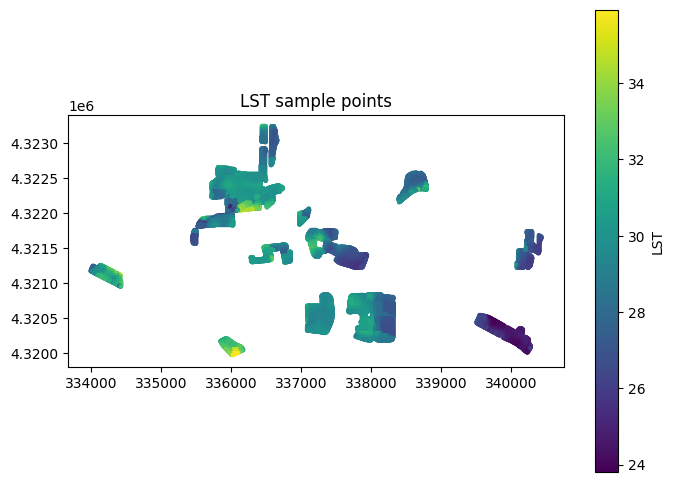

In [39]:


plt.figure(figsize=(8, 6))
plt.scatter(df_map[import_year]["x"], df_map[import_year]["y"],
            c=df_map[import_year]["lst_median"],  # Use the LST values for color
            s=4,                # point size
            cmap="viridis")
plt.colorbar(label="LST")
plt.gca().set_aspect("equal")   # preserves map scale
plt.title("LST sample points")
plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 611229 entries, 0 to 611314
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   x                  611229 non-null  float64
 1   y                  611229 non-null  float64
 2   yield              611229 non-null  float64
 3   field              611229 non-null  object 
 4   year               611229 non-null  int64  
 5   elevation          611229 non-null  float32
 6   slope              611229 non-null  float32
 7   aspect             611229 non-null  float32
 8   ndvi_mean_2022     611229 non-null  float64
 9   aspect_southness   611229 non-null  float32
 10  slope_squared      611229 non-null  float32
 11  elevation_squared  611229 non-null  float32
 12  elev_slope         611229 non-null  float32
 13  elev_aspect        611229 non-null  float32
 14  slope_aspect       611229 non-null  float32
dtypes: float32(9), float64(4), int64(1), object(1)
memory us

In [27]:
df_yield_2022.info()



<class 'pandas.core.frame.DataFrame'>
Index: 62665 entries, 445375 to 508039
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  62665 non-null  float64
 1   y                  62665 non-null  float64
 2   yield              62665 non-null  float64
 3   field              62665 non-null  object 
 4   year               62665 non-null  int64  
 5   elevation          62665 non-null  float32
 6   slope              62665 non-null  float32
 7   aspect             62665 non-null  float32
 8   aspect_southness   62665 non-null  float32
 9   slope_squared      62665 non-null  float32
 10  elevation_squared  62665 non-null  float32
 11  elev_slope         62665 non-null  float32
 12  elev_aspect        62665 non-null  float32
 13  slope_aspect       62665 non-null  float32
dtypes: float32(9), float64(3), int64(1), object(1)
memory usage: 5.0+ MB


In [42]:
# hyperparameter_tuning_xgboost
# ─────────────────────────────────────────────────────────────────────────



# ── data prep ───────────────────────────────────────────────────────────
features = ['elevation', 'slope', 'aspect',
            'aspect_southness', 'slope_aspect', 'ndvi_mean', 'lst_median']
target = 'yield'

X = df_map[2022][features]
y = np.log1p(df_map[2022][target])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ── wide search space ───────────────────────────────────────────────────
param_dist = {
    "max_depth"        : randint(3, 10),
    "min_child_weight" : randint(1, 35),
    "gamma"            : uniform(0, 1.0),
    "subsample"        : uniform(0.5, 0.5),
    "colsample_bytree" : uniform(0.5, 0.5),
    "reg_lambda"       : loguniform(1e-2, 1e2),
    "reg_alpha"        : loguniform(1e-3, 1),
    "learning_rate"    : loguniform(1e-3, 3e-1),
    "n_estimators"     : randint(400, 2001)
}

# ── base estimator — note device="cpu" & n_jobs=1 ───────────────────────
base = xgb.XGBRegressor(
    objective   = "reg:squarederror",
    eval_metric = "mae",
    tree_method = "hist",        # fastest CPU algorithm
    # device      = "cpu",         # <─ keeps the code off GPU
    # gpu_id    = 0,              # use GPU 0; set to -1 for CPU
    n_jobs      = 1,             # each fit uses 1 core; joblib handles outer parallelism
    verbosity   = 1,
    random_state= 42
)

search = RandomizedSearchCV(
    estimator           = base,
    param_distributions = param_dist,
    n_iter     = 200,            # try 200 first; 1000 can be multi-hour
    scoring    = "r2",
    cv         = 5,
    verbose    = 1,              # search-level progress
    n_jobs     = -1,
    
    random_state = 42,
    error_score = "raise"
)

# XGBoost prints every 100 trees inside each fit
# search.fit(X_train, y_train, verbose=1)


# figure out how many fits will run (candidates × folds)
total_fits = search.n_iter * (search.cv if isinstance(search.cv, int) else 5)

with tqdm_joblib(tqdm(total=total_fits, desc="RandomizedSearchCV fits", leave=True)):
    # NOTE: keep model n_jobs=1 (you have), and let CV parallelize with n_jobs=-1
    search.fit(X_train, y_train, verbose=1)   # mute per-round spam during CV

print("\n──── best params (RandomizedSearchCV) ────")
for k, v in search.best_params_.items():
    print(f"{k:18}: {v}")
print("CV-mean R² :", round(search.best_score_, 4))

# ── retrain best model WITH early stopping ──────────────────────────────
best_params = search.best_params_.copy()
best_params.update({
    "objective"            : "reg:squarederror",
    "eval_metric"          : "mae",
    "tree_method"          : "hist",
    # "device"               : "cpu",
    "n_jobs"               : 1,
    # "early_stopping_rounds": 50,
    "verbosity"            : 1,
    "random_state"         : 42
})

final_model = xgb.XGBRegressor(**best_params)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

# progress bar callback for XGBoost
class TqdmCallback(xgb.callback.TrainingCallback):
    def __init__(self, total_rounds):
        self.total = total_rounds
        self.pbar  = None
    def before_training(self, model):
        self.pbar = tqdm(total=self.total, desc="Final training (boosting rounds)", leave=True)
        return False
    def after_iteration(self, model, epoch, evals_log):
        # advance one step per boosting round
        self.pbar.update(1)
        return False  # keep training
    def after_training(self, model):
        self.pbar.close()
        return model

# use the configured n_estimators as the upper bound; early stopping may end earlier
n_rounds = final_model.get_params().get("n_estimators", 1000)
# ❌ remove evals_result kwarg
final_model.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_val, y_val)],
    early_stopping_rounds=50,
    callbacks=[TqdmCallback(total_rounds=n_rounds)],
    verbose=False
)

print(f"\nStopped after {final_model.best_iteration} boosting rounds")

# ── evaluate on Train / Val / Test (original scale) ─────────────────────
def inv_log1p(a): return np.expm1(a)
def report(tag, X_, y_):
    y_hat = inv_log1p(
        final_model.predict(X_, iteration_range=(0, final_model.best_iteration))
    )
    y_true = inv_log1p(y_)
    print(f"{tag:6} R²: {r2_score(y_true, y_hat):.3f}   "
          f"MAE: {mean_absolute_error(y_true, y_hat):.3f}   "
          f"RMSE: {mean_squared_error(y_true, y_hat, squared=False):.3f}   ")

print("\n──── performance (yield units) ───────────────────────────────")
report("Train", X_tr,  y_tr)
report("Val",   X_val, y_val)
report("Test",  X_test, y_test)


RandomizedSearchCV fits:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV fits:   0%|          | 0/1000 [26:18<?, ?it/s]


──── best params (RandomizedSearchCV) ────
colsample_bytree  : 0.6343362410126536
gamma             : 0.02218474203030163
learning_rate     : 0.01714018764811966
max_depth         : 8
min_child_weight  : 3
n_estimators      : 1729
reg_alpha         : 0.3602006572699514
reg_lambda        : 1.6129739560722722
subsample         : 0.7804689857676932
CV-mean R² : 0.8657


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:


# ---------------------------------------------------------------------
# 1 ▸ Data split (train ▸ val ▸ test)
# ---------------------------------------------------------------------
features = [
    "elevation", "slope", "aspect",
    "aspect_southness", "slope_aspect", "ndvi_mean", "lst_median"
]
target = "yield"

X = df_map[2022][features]
y = np.log1p(df_map[2022][target])          # log-transform yield

# 20 % hold-out test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 20 % of training data reserved for validation monitoring
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42
)

# ---------------------------------------------------------------------
# 2 ▸ Final model with tuned parameters + early stopping
# ---------------------------------------------------------------------
best_params = dict(
    # tuned hyper-parameters
    colsample_bytree  = 0.6343362410126536,
    gamma             = 0.02218474203030163,
    learning_rate     = 0.01714018764811966,
    max_depth         = 8,
    min_child_weight  = 3,
    n_estimators      = 1729,
    reg_alpha         = 0.3602006572699514,
    reg_lambda        = 1.6129739560722722,
    subsample         = 0.7804689857676932,
    # fixed settings
    objective        = "reg:squarederror",
    eval_metric      = "mae",
    tree_method      = "hist",              # fastest CPU algorithm
    device           = "cpu",               # remove if you have a GPU + gpu_hist
    early_stopping_rounds = 50,
    random_state     = 42,
    verbosity        = 1,                   # 0=silent, 1=warning, 2=info
)

model_soy_2022 = XGBRegressor(**best_params)

model_soy_2022.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],             # monitor validation only
    verbose=100                            # print every 100 boosting rounds
)

best_iter = model_soy_2022.best_iteration
print(f"\nStopped after {best_iter} boosting rounds")

# ---------------------------------------------------------------------
# 3 ▸ Metrics on Train ▸ Val ▸ Test (original yield scale)
# ---------------------------------------------------------------------
def report(tag, X_, y_):
    y_hat  = np.expm1(model_soy_2022.predict(X_, iteration_range=(0, best_iter)))
    y_true = np.expm1(y_)
    r2  = r2_score(y_true, y_hat)
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(((y_true - y_hat) ** 2).mean())     # sklearn<0.22 safe
    print(f"{tag:6} R²: {r2:.3f}   MAE: {mae:.3f}   RMSE: {rmse:.3f}")

print("\n──── performance (yield units) ──────────────────────────")
report("Train", X_tr,  y_tr)
report("Val",   X_val, y_val)
report("Test",  X_test, y_test)




[0]	validation_0-mae:0.27732
[100]	validation_0-mae:0.17486
[200]	validation_0-mae:0.14306
[300]	validation_0-mae:0.12759
[400]	validation_0-mae:0.11851
[500]	validation_0-mae:0.11110
[600]	validation_0-mae:0.10604
[700]	validation_0-mae:0.10198
[800]	validation_0-mae:0.09897
[900]	validation_0-mae:0.09692
[1000]	validation_0-mae:0.09553
[1100]	validation_0-mae:0.09403
[1200]	validation_0-mae:0.09319
[1300]	validation_0-mae:0.09255
[1400]	validation_0-mae:0.09199
[1500]	validation_0-mae:0.09162
[1600]	validation_0-mae:0.09117
[1700]	validation_0-mae:0.09075
[1728]	validation_0-mae:0.09066

Stopped after 1727 boosting rounds

──── performance (yield units) ──────────────────────────
Train  R²: 0.915   MAE: 3.363   RMSE: 4.530
Val    R²: 0.867   MAE: 4.149   RMSE: 5.702
Test   R²: 0.870   MAE: 4.122   RMSE: 5.649


In [47]:

y_test_pred = model_soy_2022.predict(X_test, iteration_range=(0, best_iter))

r2Test = r2_score(y_test, y_test_pred)
maeTest = mean_absolute_error(y_test, y_test_pred)

print(f"R² on test set: {r2Test:.3f}")
print(f"MAE on test set: {maeTest:.3f}")

R² on test set: 0.867
MAE on test set: 0.090


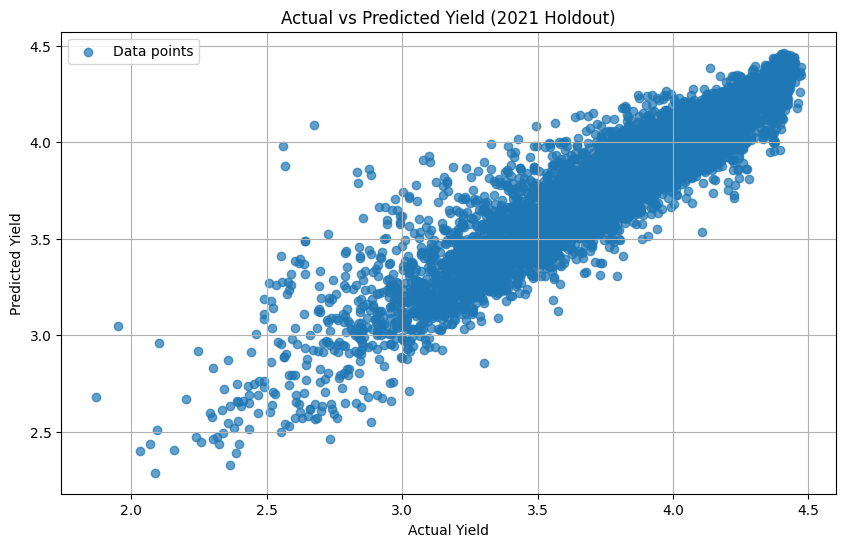

In [49]:
X = y_test.values.reshape(-1, 1)  # Actual values as X
y = y_test_pred                 # Predicted values as y
reg = LinearRegression()
reg.fit(X, y)
y_fit = reg.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, label="Data points")

# Regression line
# plt.plot(X, y, color='red', linewidth=2, label="Regression line")

# # Perfect prediction line
# plt.plot(
#     [y_21_holdout.min(), y_21_holdout.max()],
#     [y_21_holdout.min(), y_21_holdout.max()],
#     'k--', lw=2, label="Perfect prediction line"
# )

plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield (2021 Holdout)")
plt.legend()
plt.grid()
plt.show()

In [39]:
features = [
    "elevation", "slope", "aspect",
    "aspect_southness", "slope_aspect", "ndvi_mean"
]
target = "yield"

# Use this model to predict the yield for 2021
X_2021 = df_yield_2021[features]
y_2021 = np.log1p(df_yield_2021[target])

# Select a small fine-tuning subset from 2021
X_21_train, X_21_holdout, y_21_train, y_21_holdout = train_test_split(
    X_2021,
    y_2021,
    test_size=0.7,  # keep 70% for final prediction
    random_state=42
)


# Create a new model that continues from the old booster
model_finetuned_2021 = XGBRegressor(
    **best_params,  # same params as original
)

model_finetuned_2021.fit(
    X_21_train, y_21_train,
    eval_set=[(X_21_holdout, y_21_holdout)],
    verbose=100,
    xgb_model=model_soy_2022.get_booster()  # load existing trained booster
)

# Predict on the rest of 2021 data (holdout)
y_pred_holdout = model_finetuned_2021.predict(X_21_holdout, iteration_range=(0, model_finetuned_2021.best_iteration))

# Compute metrics
r2  = r2_score(y_21_holdout, y_pred_holdout)
mae = mean_absolute_error(y_21_holdout, y_pred_holdout)
rmse = np.sqrt(((y_21_holdout - y_pred_holdout) ** 2).mean())

print("──── Fine-tuned model on 2021 holdout ────")
print(f"R²   : {r2:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")


[0]	validation_0-mae:0.44794
[100]	validation_0-mae:0.13659
[200]	validation_0-mae:0.13070
[300]	validation_0-mae:0.12872
[400]	validation_0-mae:0.12778
[500]	validation_0-mae:0.12738
[600]	validation_0-mae:0.12691
[700]	validation_0-mae:0.12643
[800]	validation_0-mae:0.12620
[900]	validation_0-mae:0.12591
[1000]	validation_0-mae:0.12576
[1100]	validation_0-mae:0.12558
[1122]	validation_0-mae:0.12560
──── Fine-tuned model on 2021 holdout ────
R²   : 0.701
MAE  : 0.130
RMSE : 0.189


In [38]:
# Save model
model_soy_2022.save_model("model_soy_2022.json") 

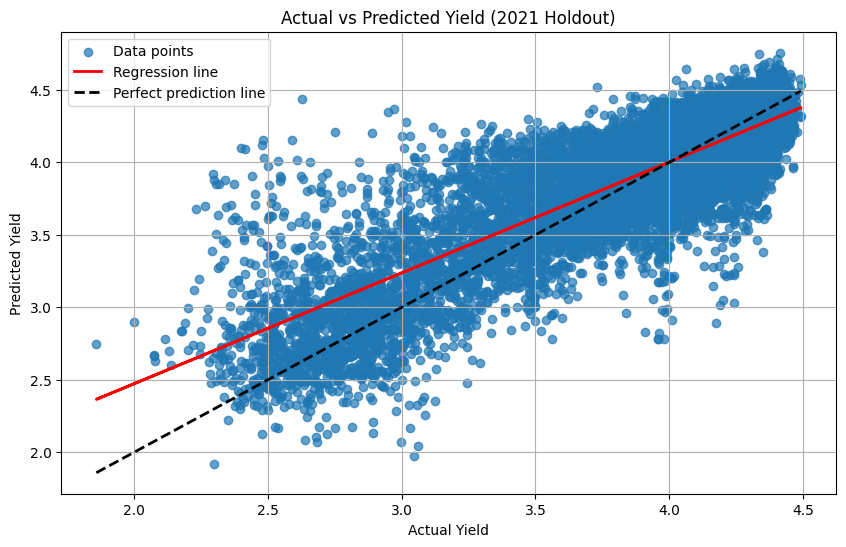

In [ ]:
#Let's build a actual yield vs predicted yield for the 2021 holdout set

X = y_21_holdout.values.reshape(-1, 1)  # Actual values as X
y = y_pred_holdout                      # Predicted values as y
reg = LinearRegression()
reg.fit(X, y)
y_fit = reg.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(y_21_holdout, y_pred_holdout, alpha=0.7, label="Data points")

# Regression line
plt.plot(y_21_holdout, y_fit, color='red', linewidth=2, label="Regression line")

# Perfect prediction line
plt.plot(
    [y_21_holdout.min(), y_21_holdout.max()],
    [y_21_holdout.min(), y_21_holdout.max()],
    'k--', lw=2, label="Perfect prediction line"
)

plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield (2021 Holdout)")
plt.legend()
plt.grid()
plt.show()
